In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano
import theano.tensor as tt

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)

## 사이즈 deFault 조정 
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


In [5]:
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

dfhogg.head()

,id,x,y,sigma_y,sigma_x,rho_xy
0,1.0,201.0,592.0,61.0,9.0,-0.84
1,2.0,244.0,401.0,25.0,4.0,0.31
2,3.0,47.0,583.0,38.0,11.0,0.64
3,4.0,287.0,402.0,15.0,7.0,-0.27
4,5.0,203.0,495.0,21.0,5.0,-0.33


In [6]:
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

In [8]:
## 표준화 작업 진행

dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)


In [9]:
# x,y의 경계선 그리기

xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5
                 ,dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5
                 ,dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)


/home/gpuadmin/.local/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


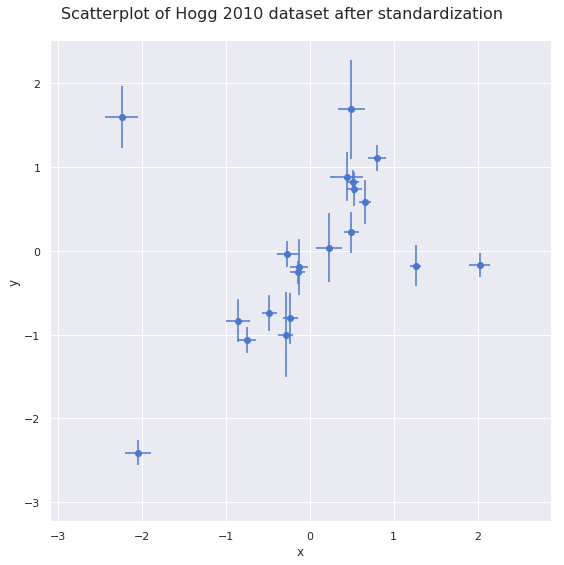

In [14]:
g = sns.FacetGrid(dfhoggs, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)
plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)

* 그림에서 보는 바와 같이 직선상에서 떨어저 있는 데이터들 존재
* $R^2$ 에 영향을 줄 수 있으므로 Outlier 라 할 수 있다.

전통적인 OLS 모델을 만들어보자 
* $y = \beta^TX + \sigma$
* $\beta$ 는 기울기 $\sigma$ 는 일반적으로 normal(0,1) 를 따른다.

* 우리가 일반적으로 알 듯이 beta0 , beta1 은 노말분포를 따르게 식을 만들 수 있다.
* 이것을 이용해서 Y도 Normal로 형태로 바꿀 수 있다.
    * $\hat \beta_0 = \beta_0 + \sum k_i\epsilon_i$   
    * $\hat \beta_1 = \beta_1 + \sum c_i\epsilon_i $
    * $\hat \beta_1 \sim N( \beta_1 , \frac{ \sigma^2  }{ S_{xx} })$ 

In [16]:
with pm.Model() as mdl_ols :
    b0 = pm.Normal("b0_intercept" , mu = 0 , sd= 1)
    b1 = pm.Normal("b1_slope" , mu =0 , sd = 1 )
    # 하나의 선형식을 만들었다.
    yest = b0 + b1 * dfhoggs["x"]
    # 
    sigma_y = theano.shared( np.asarray(dfhoggs["sigma_y"] , 
                                       dtype = theano.config.floatX),name= "sigma_y")
    likelihood = pm.Normal("likelihood" , mu = yest , sd=sigma_y , observed = dfhoggs["y"])

In [17]:
with mdl_ols:
    ## take samples
    traces_ols = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1_slope, b0_intercept]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3881.22draws/s]


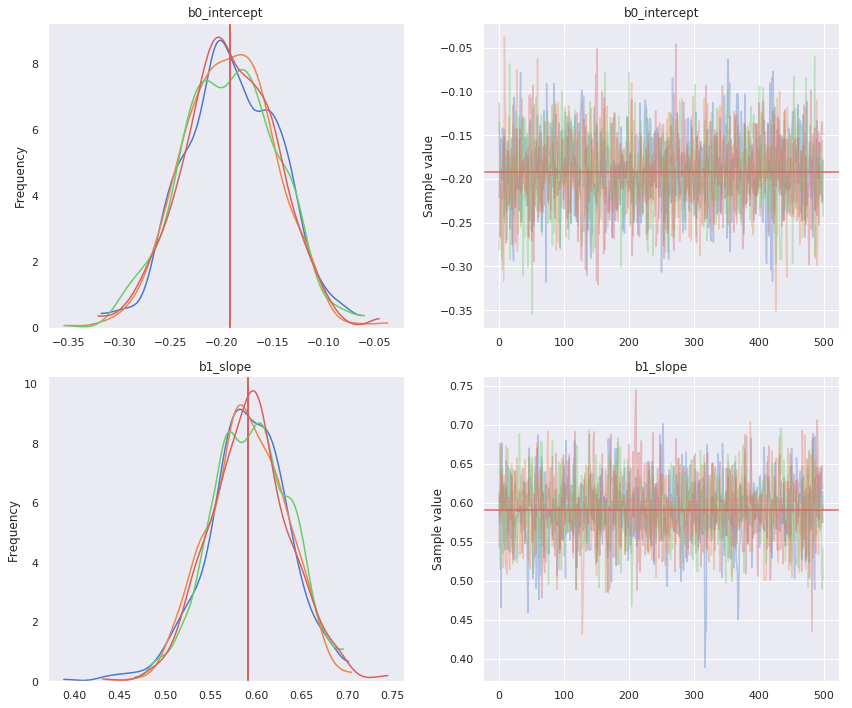

In [22]:

_ = pm.traceplot(traces_ols, figsize=(12, len(traces_ols.varnames)*5),
                lines={k: v['mean'] for k, v in pm.summary(traces_ols[-1000:]).iterrows()})

## 이번에는 Robust Model : Student -T Method 활용해서 만들자.
* 바뀐것은 normal 대신 꼬리가 더 두꺼운 student - t 를 쓰겠다는 것이다.
    * 이론상, 그것을 가능도안에서 mse를 작게 할 수 있다. 그래서 더 영향을 덜 받게 된다.
   

In [23]:
with pm.Model() as mdl_studentt :
    b0 = pm.Normal( "bo_intercept" , mu = 0 , sd = 1)
    b1 = pm.Normal("b1_slope" , mu =0 ,sd = 1)
    
    yest = b0 + b1 * dfhoggs["x"]
    
    sigma_y = theano.shared( np.asarray(dfhoggs["sigma_y"] , dtype = theano.config.floatX) , name = 'sigma_y')
    
    ## student -t 분포에 아는 것이 없다가정하여 사전지식을 무정보를 사용한다.
    nu = pm.Uniform( "NU" , lower= 1, upper=100)
    
    ## Define Student T likelihood
    likelihood = pm.StudentT( "likelihood" , mu = yest , sd= sigma_y , nu = nu , observed = dfhoggs["y"])

In [28]:
with mdl_studentt : 
    traces_studentt = pm.sample(tune=2000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NU, b1_slope, bo_intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2606.25draws/s]


In [29]:
pm.summary(traces_studentt[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bo_intercept,-0.005250,0.084054,0.002746,-0.165280,0.162377,952.369472,1.002035
b1_slope,1.205459,0.098517,0.002966,1.031033,1.431674,974.309121,0.999500
NU,1.469255,0.381618,0.009541,1.000793,2.240801,1628.583724,1.000622


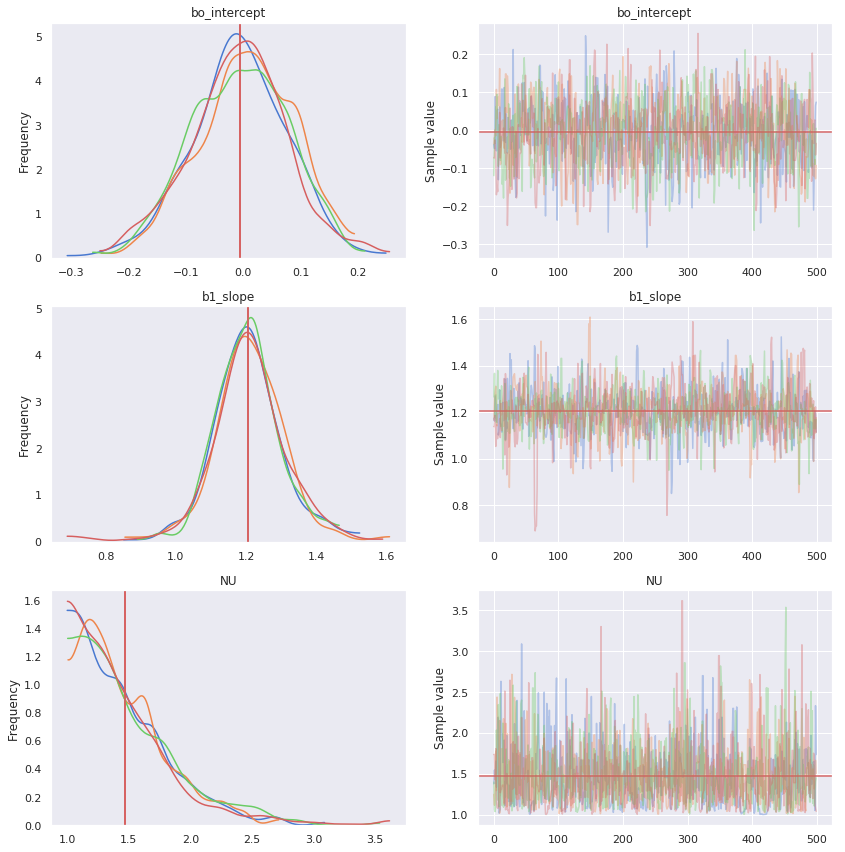

In [30]:
_ = pm.traceplot(traces_studentt,
                 figsize=(12,len(traces_studentt.varnames)*3),
                 lines={k: v['mean'] for k, v in pm.summary(traces_studentt[-1000:]).iterrows()})

* $\beta_0 , \beta_1$ 은 오른쪽에서 치우치게 보인다.  
* 이것은 아마도 왼쪽으로 향하는 OLS 추정치에 더 근접한 약간의 표본들의 작용 일 것이다(구글번역)
* $\nu$ 는 1의 값에서 뾰족하다. 이것이 암시하는 것은 Normal 로 fitting 하는 것보다 꼬리가 두꺼운 student t 분포가 더 적합하다고 하는 것 같다고 한다.
* inference sampling 역시 ols 만큼이나 빨리 된다.

## Create Robust Model with Outliers: Hogg Method [Url](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html)
* Please read the paper (Hogg 2010) and Jake Vanderplas’ code for more complete information about the modelling technique.
* The general idea is to create a ‘mixture’ model whereby datapoints can be described by either the linear model (inliers) or a modified linear model with different mean and larger variance (outliers).
* **구글번역**(일반적인 아이디어는 선형 모델 (inliers) 또는 다른 평균과 큰 분산 (이상 치)을 가진 수정 된 선형 모델로 데이터 포인트를 기술 할 수있는 '혼합'모델을 만드는 것입니다.)
* The likelihood is evaluated over a mixture of two likelihoods, one for ‘inliers’, one for ‘outliers’. A Bernouilli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:
* **구글번역** 
가능성은 두 가지 가능성, 즉 하나는 'inliers', 하나는 'outliers'에 대해 평가됩니다. Bernouilli 분포는 N의 데이터 점을 inlier 또는 outlier 그룹에 무작위로 할당하는 데 사용되며 강력한 모델 매개 변수와 inlier / outlier 플래그를 추론하기 위해 평소처럼 모델을 샘플링합니다.

* 이번엔 **theano** 가 아닌 pymc3 패캐지를 활용하여 시행한다. Normal logp 랑 Potental 이 효율적이다고 한다.

![](./glm_img.PNG)

* 밑에 구현된 것을 잘 보면 위에 식을 구현한 것이다.

In [31]:
with pm.Model() as mdl_signoise : 
    ## ## Define informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0_intercept" , mu = 0 ,sd=1, testval = pm.floatX(0.1))
    b1 = pm.Normal("b1_slope" , mu =0 ,sd = 1 , testval = pm.floatX(1.))
    
    ## Define
    yest_in = b0 + b1 * dfhoggs["x"]
    
    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=10, testval=pm.floatX(1.))
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=10, testval=pm.floatX(1.))
    
    ## Define Bernoulli inlier / outlier flags according to a hyperprior
    ## fraction of outliers, itself constrained to [0, .5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0],
                              testval=np.random.rand(dfhoggs.shape[0]) < 0.2)
    
    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = theano.shared(np.asarray(dfhoggs['y'], dtype=theano.config.floatX))
    sigma_y_in = np.asarray(dfhoggs['sigma_y'], dtype=theano.config.floatX)
    
    # Set up normal distributions that give us the logp for both distributions
    inliers = pm.Normal.dist(mu=yest_in, sd=sigma_y_in).logp(yobs)
    outliers = pm.Normal.dist(mu=yest_out, sd=sigma_y_in + sigma_y_out).logp(yobs)
    
    # Build custom likelihood, a potential will just be added to the logp and can thus function
    # like a likelihood that we would add with the observed kwarg.
    pm.Potential('obs', ((1 - is_outlier) * inliers).sum() + (is_outlier * outliers).sum())
    

In [32]:
with mdl_signoise:
    traces_signoise = pm.sample(tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, yest_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:21<00:00, 1018.53draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9011018103431498, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8959224906054892, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5379324409461452, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% f

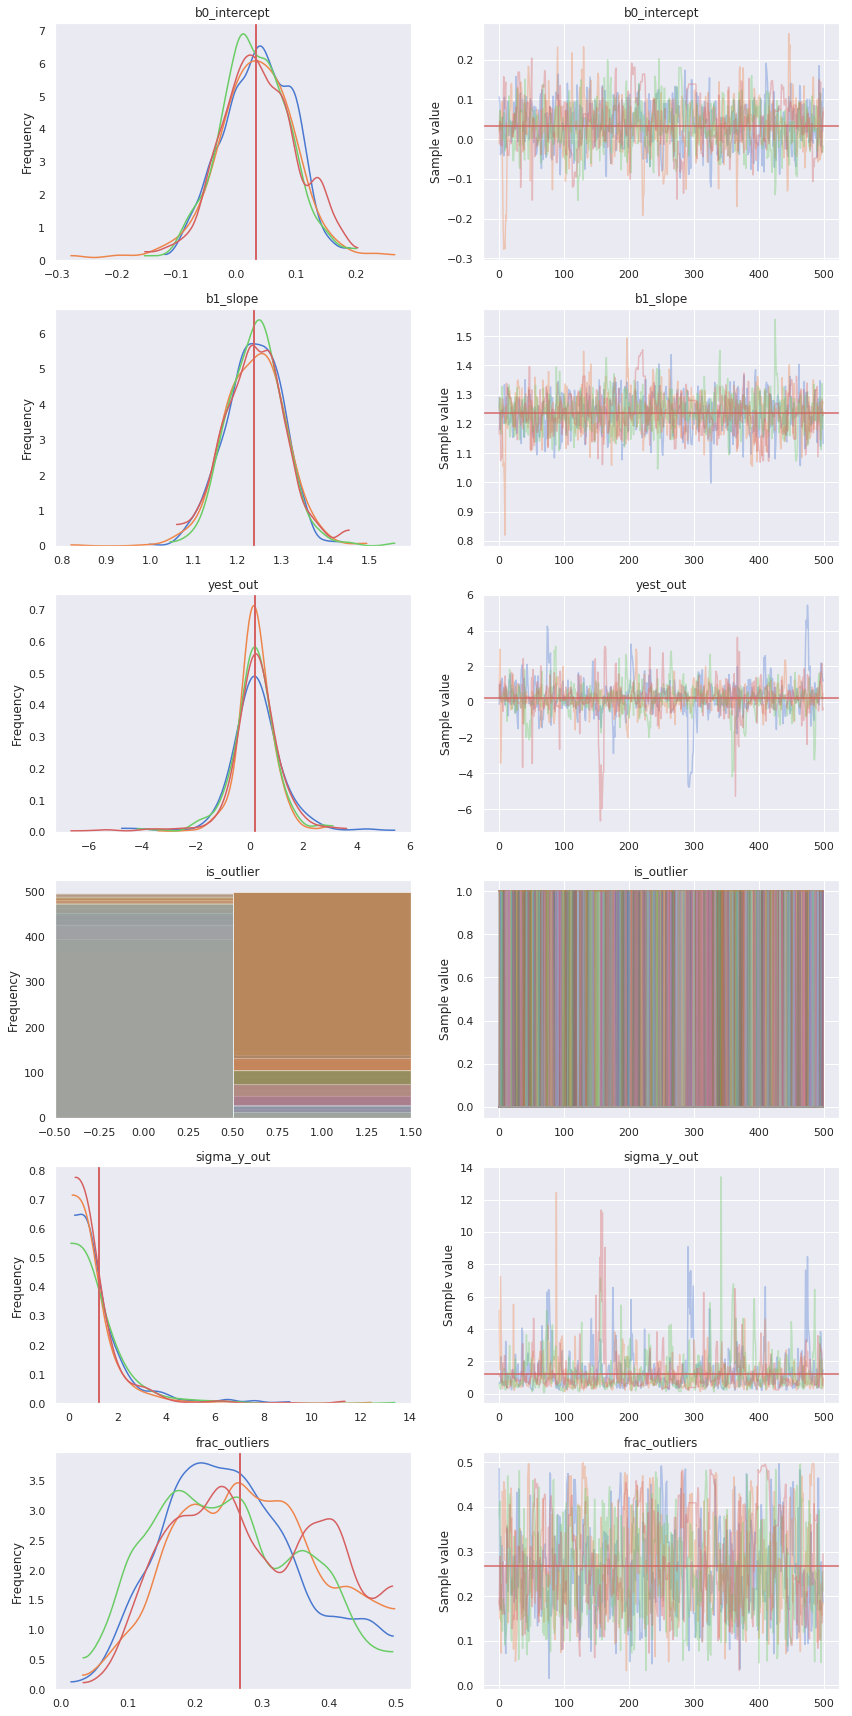

In [33]:

_ = pm.traceplot(traces_signoise, figsize=(12, len(traces_signoise.varnames)*3),
            lines={k: v['mean'] for k, v in pm.summary(traces_signoise).iterrows()})